In [1]:
from glob import glob
from random import shuffle
import cv2
import numpy as np

In [2]:
DATADIR = "Dataset/"
NO_CLASS_LABEL='noclass'
IMG_SIZE = 100
IMG_CHANNELS=3
TRAIN_TEST_RATIO = 0.2

epochs = 16
batch_size = 32

In [3]:
# List image addresses

labels = glob(DATADIR+'*/')

labels.insert(0, labels.pop(np.argmax([x.find(NO_CLASS_LABEL) for x in labels]))) # Push 'noclass' to the beginning

label_count = len(labels)
addrs = []

for (index, path) in enumerate(labels):
    img_addrs = glob(path+"*")
    for img_addr in img_addrs:
        addrs.append((img_addr, index))
        
shuffle(addrs)

division = int(len(addrs) * TRAIN_TEST_RATIO)
train_addrs = addrs[division:]
valid_addrs = addrs[0:division]

In [4]:
# Read dataset into memory
x_train = np.zeros( (len(train_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int ) # Keras input: (img_height, img_width, img_depth)
y_train_list = np.zeros( len(train_addrs), dtype=np.int )

x_valid = np.zeros( (len(valid_addrs), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.int )
y_valid_list = np.zeros( len(valid_addrs), dtype=np.int )

# Train data
for i in range(len(train_addrs)):
    addr = train_addrs[i][0]
    label = train_addrs[i][1]
    img = cv2.imread(addr)
    height, width, c = img.shape
    start_col = int(max(width/2-height/2, 0))
    end_col = int(min(start_col+height, width))
    img = img[:, start_col:end_col, ... ]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_train[i, ...] = img
    y_train_list[i] = label
    
# Validation data
for i in range(len(valid_addrs)):    
    addr = valid_addrs[i][0]
    label = valid_addrs[i][1]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    x_valid[i, ...] = img
    y_valid_list[i] = label
    

In [7]:
# One hot encode labels
y_train = np.zeros((y_train_list.shape[0],label_count),dtype=np.float)
y_valid = np.zeros((y_valid_list.shape[0],label_count),dtype=np.float)

y_train[np.arange(y_train.shape[0]), y_train_list] = 1.0
y_valid[np.arange(y_valid.shape[0]), y_valid_list] = 1.0

In [128]:
# Custom loss function

import tensorflow.keras.backend as K

def customLoss(yTrue,yPred):
    n = yTrue.shape[0]
    yTrueBinary = yTrue[:, 0:1]
    yPredBinary =  yPred[:, 0:1]
    yTrueCategorical = yTrue[:, 1:]
    yPredCategorical = yPred[:, 1:]    
    
    bce = K.mean(K.binary_crossentropy(yTrueBinary, yPredBinary))
    cce = K.mean(K.categorical_crossentropy(yTrueCategorical, yPredCategorical))
    loss = bce + cce
    #print('\nbce=', bce)
    #print('cce=', cce)
    #print('loss=', loss)
    # loss = K.binary_crossentropy(yTrue[0:1], yPred[0:1]) + K.categorical_crossentropy(yTrue[1:], yPred[1:])
    return loss

In [129]:
# Define model

from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, Concatenate

rmsprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9)

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))
conv1 = Conv2D(32, kernel_size=4, activation='relu')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(64, kernel_size=4, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2)

flat = Flatten()(pool3)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.22)(hidden1)

output1 = Dense(1, activation='sigmoid')(drop1)
output2 = Dense(label_count-1, activation='softmax')(drop1)
output = Concatenate()([output1, output2])

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=rmsprop,
              loss=customLoss,
              metrics=['accuracy'])

In [157]:
# Load weights
model.load_weights('model.h5')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0,)

In [8]:
gen = valid_datagen.flow(x_train, y_train, batch_size=batch_size)
x,y = gen.next()

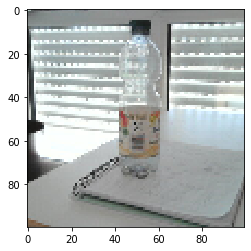

[0. 1. 0.]


In [16]:
import matplotlib.pyplot as plt
index = 3
plt.imshow(x[index])
plt.show()
print(y[index])

In [158]:
# Train model 

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size, epochs=epochs, 
                    validation_data=valid_datagen.flow(x_valid, y_valid, batch_size=batch_size))

Epoch 1/16
15/14 [================================] - 1s 77ms/step - loss: 1.3122 - accuracy: 0.2978 - val_loss: 1.1503 - val_accuracy: 0.3304
Epoch 2/16
15/14 [================================] - 1s 75ms/step - loss: 1.0904 - accuracy: 0.3067 - val_loss: 1.1345 - val_accuracy: 0.3304
Epoch 3/16
15/14 [================================] - 1s 72ms/step - loss: 1.1935 - accuracy: 0.3600 - val_loss: 1.0840 - val_accuracy: 0.3214
Epoch 4/16
15/14 [================================] - 1s 68ms/step - loss: 1.0321 - accuracy: 0.3178 - val_loss: 1.0672 - val_accuracy: 0.3750
Epoch 5/16
15/14 [================================] - 1s 71ms/step - loss: 1.0751 - accuracy: 0.3978 - val_loss: 0.9636 - val_accuracy: 0.5179
Epoch 6/16
15/14 [================================] - 1s 70ms/step - loss: 0.9968 - accuracy: 0.4289 - val_loss: 0.9082 - val_accuracy: 0.5804
Epoch 7/16
15/14 [================================] - 1s 70ms/step - loss: 0.9380 - accuracy: 0.5022 - val_loss: 0.9760 - val_accuracy: 0.4554

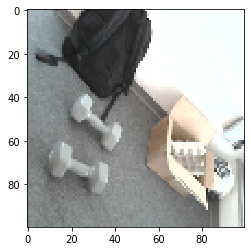

[[0.31011257 0.81829315 0.18170685]]
[1. 0. 0.]


In [173]:
# Test model

index = 29

x,y = gen.next()
image = x[index:index+1]
true = y[index]
plt.imshow(image[0])
plt.show()

pred = model.predict(image)

print(pred)
print(true)

In [54]:
# Save weights 
model.save_weights('model.h5')